In [1]:
import pandas as pd
def load_data(path):
    """Load dataset from a CSV file located in the specified directory."""
    return pd.read_csv(path)

In [2]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(path):
    """Preprocess data: handle missing values, encode categorical variables, etc."""
    dataset = load_data(path)
    # Renaming columns for better readability
    data = dataset.rename(columns={
        'Y': 'StudentAchievementScore',
        'Z': 'GrowthMindsetIntervention',
        'S3': 'FutureSuccessExpectations',
        'C1': 'StudentRaceEthnicity',
        'C2': 'StudentGender',
        'C3': 'FirstGenCollegeStatus',
        'XC': 'SchoolUrbanicity',
        'X1': 'PreInterventionFixedMindset',
        'X2': 'SchoolAchievementLevel',
        'X3': 'SchoolMinorityComposition',
        'X4': 'PovertyConcentration',
        'X5': 'TotalStudentPopulation'
    })

    # One-hot encoding for categorical variables
    categorical_columns = ['StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 'SchoolUrbanicity']
    data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

    # Standardizing numerical columns
    numerical_columns = ['PreInterventionFixedMindset', 'SchoolAchievementLevel', 
                         'SchoolMinorityComposition', 'PovertyConcentration', 'TotalStudentPopulation']
    scaler = StandardScaler()
    data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

    return data_encoded

In [3]:
# Import the necessary functions from the scripts
from models.Meta_Learners.s_Learner import s_fit, predict_outcomes, estimate_CATE
from models.Meta_Learners.x_learner import x_fit, predict_outcomes_x, estimate_CATE_x
from models.Meta_Learners.r_learner import r_fit, predict_outcomes_r, estimate_CATE_r
from models.Meta_Learners.t_learner import t_fit, predict_outcomes_t, estimate_CATE_t
from data import data_preprocessing
import pandas as pd


class TrainAndPredict:
    def __init__(self, data):
        """
        Initialize the TrainAndPredict class with the dataset.

        Parameters:
        data: pd.DataFrame, the preprocessed dataset
        """
        self.data = data

    def extract_features(self):
        """
        Extract covariates, treatment, and outcome from preprocessed data.

        Returns:
        treatment_col: str, treatment assignment column name
        outcome_col: str, outcome variable column name
        covariate_cols: list of str, covariate variable column names
        """
        # Define columns
        treatment_col = 'GrowthMindsetIntervention'
        outcome_col = 'StudentAchievementScore'
        covariate_cols = [
            'FutureSuccessExpectations', 'StudentRaceEthnicity', 'StudentGender',
            'FirstGenCollegeStatus', 'SchoolUrbanicity', 'PreInterventionFixedMindset',
            'SchoolAchievementLevel', 'SchoolMinorityComposition', 'PovertyConcentration',
            'TotalStudentPopulation'
        ]
        return treatment_col, outcome_col, covariate_cols

    def train_and_predict(self):
        """
        Train the S-Learner model and predict the CATE.

        Returns:
        CATE: pd.Series, the Conditional Average Treatment Effect estimates
        """
        treatment_col, outcome_col, covariate_cols = self.extract_features()

        # S-Learner
        s_model = s_fit(self.data, treatment_col, outcome_col, covariate_cols)
        s_predictions = predict_outcomes(self.data[covariate_cols], s_model, treatment_col)
        s_cate = estimate_CATE(s_predictions)
        data_with_s_cate = self.data.copy()
        data_with_s_cate['CATE'] = s_cate

        # T-Learner
        t_model_treated, t_model_control = t_fit(self.data, treatment_col, outcome_col, covariate_cols)
        t_predictions = predict_outcomes_t(self.data[covariate_cols], t_model_treated, t_model_control)
        t_cate = estimate_CATE_t(t_predictions)
        data_with_t_cate = self.data.copy()
        data_with_t_cate['CATE'] = t_cate

        # X-Learner
        x_model_treated, x_model_control = x_fit(self.data, treatment_col, outcome_col, covariate_cols)
        x_predictions = predict_outcomes_x(self.data[covariate_cols], x_model_treated, x_model_control)
        x_cate = estimate_CATE_x(x_predictions)
        data_with_x_cate = self.data.copy()
        data_with_x_cate['CATE'] = x_cate

        # R-Learner
        r_tau_model, r_y_model, r_t_model, y_residual, t_residual = r_fit(self.data, treatment_col, outcome_col,
                                                                          covariate_cols)
        print(y_residual.describe())
        print(t_residual.describe())
        r_predictions = predict_outcomes_r(self.data[covariate_cols], r_tau_model, r_y_model, r_t_model)
        r_cate = estimate_CATE_r(r_predictions)
        data_with_r_cate = self.data.copy()
        data_with_r_cate['CATE'] = r_cate
        # print(f"y residual{max(y_residual),min(y_residual)}, t residual {max(t_residual),min(t_residual)}")
        y_arry = pd.DataFrame(y_residual)
        t_arry = pd.DataFrame(t_residual)
        print(t_arry.describe())
        print(y_arry.describe())

        return data_with_s_cate, data_with_t_cate, data_with_x_cate, data_with_r_cate


In [4]:
# Example usage within the same script, if run as a standalone for testing:
from data import data_preprocessing
processed_data = data_preprocessing.preprocess_data(path='../data/dataset.csv')  # Get the preprocessed data
tp = TrainAndPredict(processed_data)
s_estimates, t_estimates, x_estimates, r_estimates = tp.train_and_predict()

division result : count    10391.000000
mean         0.267967
std          1.217603
min         -4.962407
25%         -0.434583
50%          0.267780
75%          1.016669
max          4.045960
dtype: float64
tau model coefficient :[ 0.04275259 -0.00184482 -0.00396038 -0.02451693  0.00554496 -0.06147452
 -0.00477654 -0.00125276  0.01629916  0.03119763]
count    1.039100e+04
mean    -3.555791e-17
std      1.000048e+00
min     -2.790976e+00
25%     -6.948567e-01
50%     -1.396486e-02
75%      6.634494e-01
max      3.423158e+00
Name: StudentAchievementScore, dtype: float64
count    10391.000000
mean        -0.033924
std          0.611827
min         -0.796304
25%         -0.511929
50%         -0.359347
75%          0.771510
max          1.055986
Name: GrowthMindsetIntervention, dtype: float64
       GrowthMindsetIntervention
count               10391.000000
mean                   -0.033924
std                     0.611827
min                    -0.796304
25%                    -0.511929
5

In [5]:
import pandas as pd


# Add a learner identifier column
s_estimates['Learner'] = 'S-Learner'
t_estimates['Learner'] = 'T-Learner'
x_estimates['Learner'] = 'X-Learner'
r_estimates['Learner'] = 'R-Learner'

# Combine all the estimates into one DataFrame
combined_data = pd.concat([s_estimates, t_estimates, x_estimates, r_estimates], ignore_index=True)

# Optionally, print or return the combined data
print(combined_data)

       schoolid  GrowthMindsetIntervention  StudentAchievementScore  \
0            76                          1                 0.081602   
1            76                          1                -0.385869   
2            76                          1                 0.398184   
3            76                          1                -0.175037   
4            76                          1                 0.884583   
...         ...                        ...                      ...   
41559         1                          0                 0.423366   
41560         1                          0                -0.197092   
41561         1                          0                 0.141698   
41562         1                          0                -0.351565   
41563         1                          0                 0.211240   

       FutureSuccessExpectations  StudentRaceEthnicity  StudentGender  \
0                              6                     4              2   
1

In [6]:
# List of features to calculate CATE for
features = [
     'GrowthMindsetIntervention', 'FutureSuccessExpectations',
    'StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 'SchoolUrbanicity',
    'PreInterventionFixedMindset', 'SchoolAchievementLevel', 'SchoolMinorityComposition',
    'PovertyConcentration', 'TotalStudentPopulation'
]

# Initialize a dictionary to hold CATE results
cate_results = {}

# Function to calculate CATE for a given feature
def calculate_cate(feature):
    grouped_data = combined_data.groupby(['Learner', feature]).agg({'CATE': 'mean'}).reset_index()
    grouped_data.columns = ['Learner', feature, 'CATE']
    return grouped_data

# Calculate CATE for each feature and store the results
for feature in features:
    cate_results[feature] = calculate_cate(feature)

In [7]:
# Calculate Real-World Treatment Effects
real_world_effects = {}

for feature in features:
    # Group by the feature and treatment
    grouped_data = combined_data.groupby([feature, 'GrowthMindsetIntervention'])['StudentAchievementScore'].mean().unstack()
    
    # Calculate the real-world treatment effect as the difference between treated and control
    real_world_effect = grouped_data[1] - grouped_data[0]
    
    # Store the result
    real_world_effects[feature] = real_world_effect

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a new DataFrame to compare the predicted CATE with real-world treatment effects
comparison_matrix_with_real = pd.DataFrame(index=features, columns=['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner', 'Real-World Effect'])

# Fill the matrix with the predicted CATE values and real-world treatment effects
for feature in features:
    for learner in ['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner']:
        learner_data = cate_results[feature]
        mean_cate = learner_data[learner_data['Learner'] == learner]['CATE'].mean()
        comparison_matrix_with_real.loc[feature, learner] = mean_cate
        
    # Fill in the real-world effect for the feature
    comparison_matrix_with_real.loc[feature, 'Real-World Effect'] = real_world_effects[feature].mean()

In [9]:
# Step 1: Check for missing values in the relevant columns
missing_values = combined_data[['GrowthMindsetIntervention', 'StudentAchievementScore']].isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 GrowthMindsetIntervention    0
StudentAchievementScore      0
dtype: int64


In [10]:
# Step 2: Inspect data for GrowthMindsetIntervention to see if treated or control group has insufficient data
print("\nData distribution for GrowthMindsetIntervention:")
print(combined_data['GrowthMindsetIntervention'].value_counts())


Data distribution for GrowthMindsetIntervention:
GrowthMindsetIntervention
0    28028
1    13536
Name: count, dtype: int64


In [11]:
# Step 3: Investigate the distribution of StudentAchievementScore for treated and control groups
treated_scores = combined_data[combined_data['GrowthMindsetIntervention'] == 1]['StudentAchievementScore']
control_scores = combined_data[combined_data['GrowthMindsetIntervention'] == 0]['StudentAchievementScore']

In [12]:
print("\nTreated group scores (first few rows):")
print(treated_scores.head())

print("\nControl group scores (first few rows):")
print(control_scores.head())


Treated group scores (first few rows):
0    0.081602
1   -0.385869
2    0.398184
3   -0.175037
4    0.884583
Name: StudentAchievementScore, dtype: float64

Control group scores (first few rows):
3384   -1.434893
3385    0.999290
3386    0.197742
3387   -0.059160
3388   -0.041489
Name: StudentAchievementScore, dtype: float64


In [13]:
# Manually calculate the mean scores for treated and control groups
mean_treated_score = treated_scores.mean()
mean_control_score = control_scores.mean()

# Calculate the real-world effect
real_world_effect_growth_mindset = mean_treated_score - mean_control_score
print("\nManually Recalculated Real-World Effect for GrowthMindsetIntervention:", real_world_effect_growth_mindset)


Manually Recalculated Real-World Effect for GrowthMindsetIntervention: 0.3036748422490183


In [14]:
# Update the comparison matrix with the manually recalculated real-world effect
comparison_matrix_with_real.loc['GrowthMindsetIntervention', 'Real-World Effect'] = real_world_effect_growth_mindset

# Display the updated comparison matrix
print("\nUpdated comparison matrix with recalculated Real-World Effect:")
print(comparison_matrix_with_real)


Updated comparison matrix with recalculated Real-World Effect:
                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.254728  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.233708  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.259011  0.278262    0.2606  0.248819   
StudentGender                0.253108  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.256059  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.247483  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.239509  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.239509  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.239509  0.278851  0.238911  0.240691   
PovertyConcentration         0.239509  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.239509  0.278851  0.238911  0.240691   

                            Real-World Effect  
GrowthMindsetIntervention          

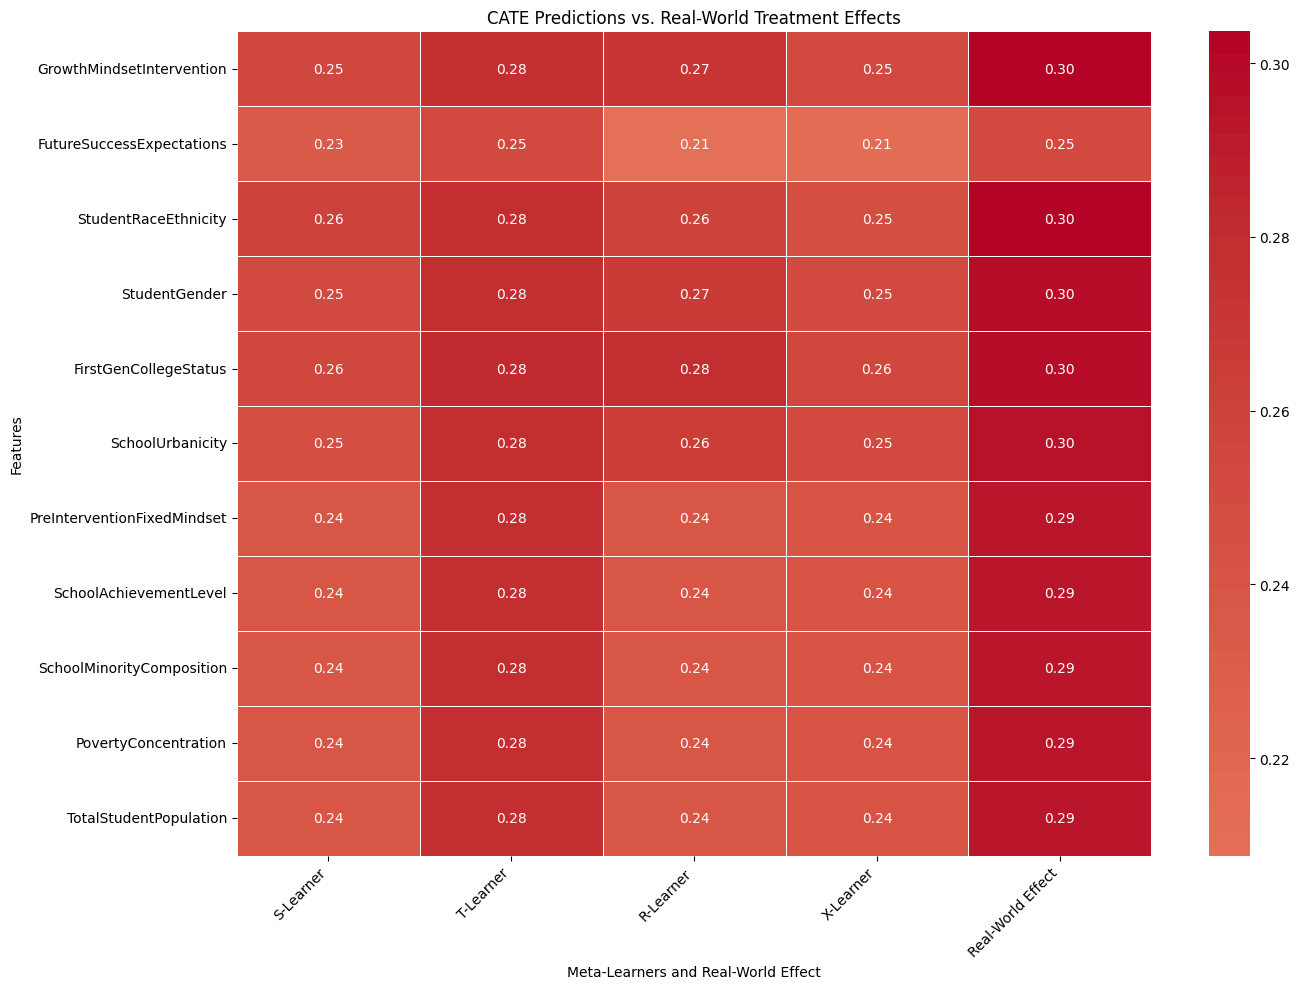

In [15]:
# Visualize the Comparison
plt.figure(figsize=(14, 10))

# Heatmap showing both CATE predictions and real-world effects
sns.heatmap(comparison_matrix_with_real.astype(float), annot=True, cmap="coolwarm", center=0, cbar=True, fmt=".2f", linewidths=.5)

plt.title('CATE Predictions vs. Real-World Treatment Effects')
plt.xlabel('Meta-Learners and Real-World Effect')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


Best Learner for each feature:
                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.254728  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.233708  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.259011  0.278262    0.2606  0.248819   
StudentGender                0.253108  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.256059  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.247483  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.239509  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.239509  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.239509  0.278851  0.238911  0.240691   
PovertyConcentration         0.239509  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.239509  0.278851  0.238911  0.240691   

                            Real-World Effect     Best Learner  
GrowthMindsetIntervention            0.303675  T-L

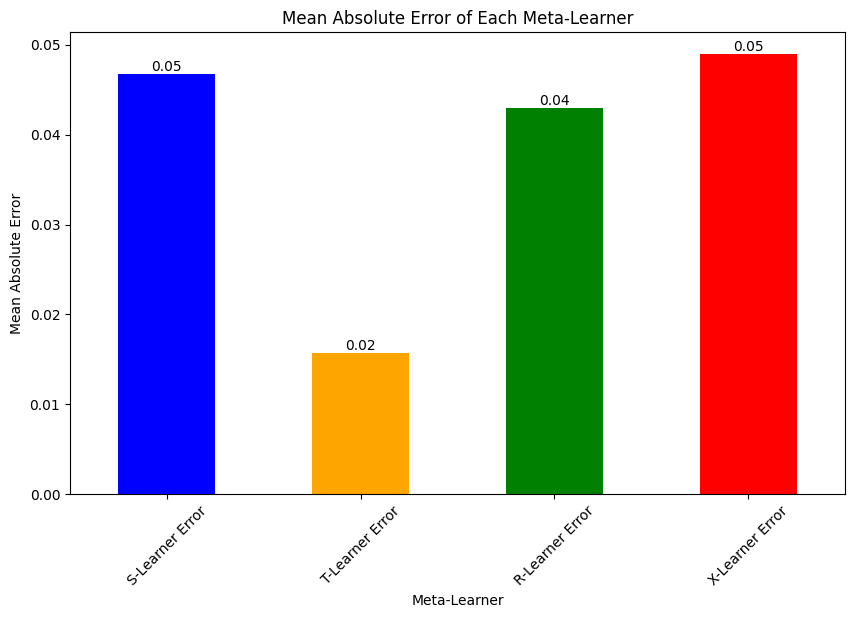


Updated comparison matrix with error calculations:
                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.254728  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.233708  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.259011  0.278262    0.2606  0.248819   
StudentGender                0.253108  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.256059  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.247483  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.239509  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.239509  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.239509  0.278851  0.238911  0.240691   
PovertyConcentration         0.239509  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.239509  0.278851  0.238911  0.240691   

                            Real-World Effect  S-Learner Error  \
GrowthMindsetIntervention    

In [16]:
import numpy as np
import pandas as pd

# Calculate the absolute error for each learner
comparison_matrix_with_real['S-Learner Error'] = abs(comparison_matrix_with_real['S-Learner'] - comparison_matrix_with_real['Real-World Effect'])
comparison_matrix_with_real['T-Learner Error'] = abs(comparison_matrix_with_real['T-Learner'] - comparison_matrix_with_real['Real-World Effect'])
comparison_matrix_with_real['R-Learner Error'] = abs(comparison_matrix_with_real['R-Learner'] - comparison_matrix_with_real['Real-World Effect'])
comparison_matrix_with_real['X-Learner Error'] = abs(comparison_matrix_with_real['X-Learner'] - comparison_matrix_with_real['Real-World Effect'])

# Ensure all errors are numeric and handle NaN values by filling them with a large number (infinity)
comparison_matrix_with_real['S-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['S-Learner Error'], errors='coerce').fillna(np.inf)
comparison_matrix_with_real['T-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['T-Learner Error'], errors='coerce').fillna(np.inf)
comparison_matrix_with_real['R-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['R-Learner Error'], errors='coerce').fillna(np.inf)
comparison_matrix_with_real['X-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['X-Learner Error'], errors='coerce').fillna(np.inf)

# Identify the best learner for each feature by finding the minimum error
comparison_matrix_with_real['Best Learner'] = comparison_matrix_with_real[['S-Learner Error', 'T-Learner Error', 'R-Learner Error', 'X-Learner Error']].idxmin(axis=1)

print("\nBest Learner for each feature:")
print(comparison_matrix_with_real[['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner', 'Real-World Effect', 'Best Learner']])

# Visualize the results using bar plots
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
mean_errors = comparison_matrix_with_real[['S-Learner Error', 'T-Learner Error', 'R-Learner Error', 'X-Learner Error']].mean()
bars = mean_errors.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])

# Add the actual value at the top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), 
             ha='center', va='bottom')

plt.title('Mean Absolute Error of Each Meta-Learner')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Meta-Learner')
plt.xticks(rotation=45)
plt.show()

# Display the updated comparison matrix with error calculations
print("\nUpdated comparison matrix with error calculations:")
print(comparison_matrix_with_real)


These visualizations show the distribution of Conditional Average Treatment Effect (CATE) estimates by different demographic subgroups using four meta-learners: S-Learner, T-Learner, X-Learner, and R-Learner. By analyzing these box plots, we can compare how each meta-learner estimates the effect of the growth mindset intervention across these demographic groups.

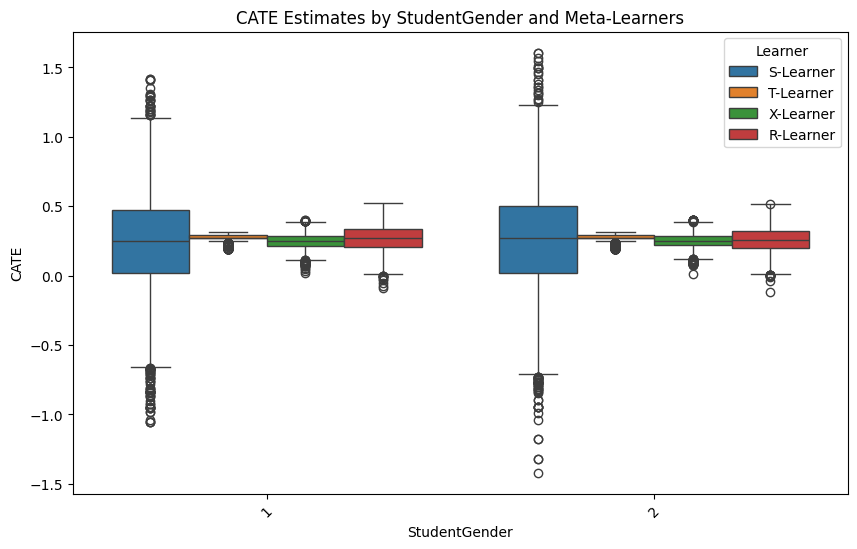

In [17]:
def plot_cate_by_demographic(feature):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='CATE', hue='Learner', data=combined_data)
    plt.title(f'CATE Estimates by {feature} and Meta-Learners')
    plt.ylabel('CATE')
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.show()
# Plot for Gender
plot_cate_by_demographic('StudentGender')


This boxplot shows the distribution of CATE estimates for different genders (encoded as 1 and 2 for male and female) across four meta-learners.

* Key Observations:

    * Male Group (1):
    The R-Learner estimates a higher median treatment effect for males compared to the other learners, with its CATE estimates centering around 0.3.
    The S-Learner shows a wider spread of CATE estimates for males, with a few negative estimates and a lower median effect (~0.2).
    The X-Learner has the lowest spread for males, predicting a smaller treatment effect (~0.2).

    * Female Group (2):
    The R-Learner again estimates the highest treatment effect for females (~0.4), with more consistency across predictions.
    Other learners (S, T, and X) show more conservative treatment effects for females, with medians around 0.2-0.3.

* Interpretation:

    * R-Learner consistently predicts higher treatment effects across both genders, suggesting it may be more sensitive to the features of the intervention.
    * Gender Differences: The R-Learner suggests a potentially stronger effect of the intervention for females, while the other learners show only a small difference between genders.

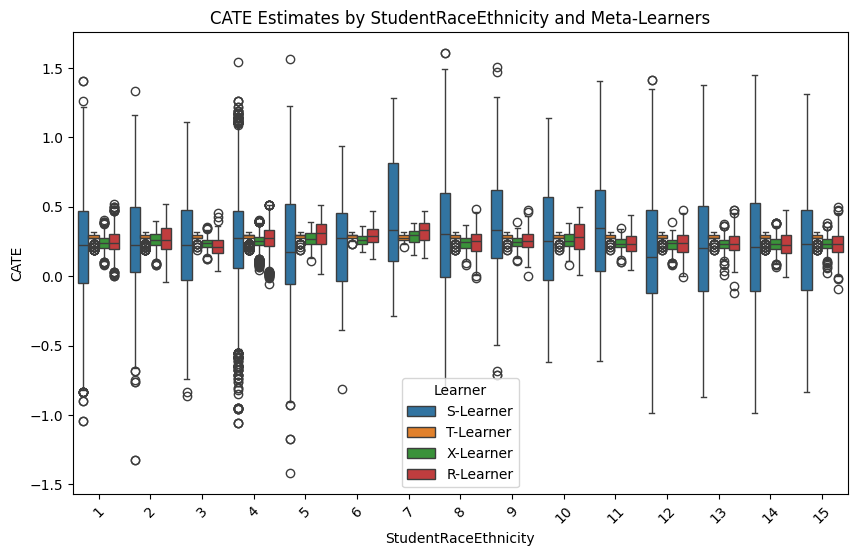

In [18]:
# Plot for Race/Ethnicity
plot_cate_by_demographic('StudentRaceEthnicity')

2. CATE Estimates by Race/Ethnicity
This boxplot shows the distribution of CATE estimates for different racial/ethnic groups (StudentRaceEthnicity) across the four meta-learners.
* Key Observations:

    * There is considerable variation in CATE estimates across racial/ethnic groups, suggesting that the treatment effect of the growth mindset intervention may vary depending on race/ethnicity.
    * For most groups, the R-Learner generally predicts higher treatment effects compared to the other learners, with more spread in its estimates.
    * The S-Learner and X-Learner predict lower and more conservative CATE estimates across most groups.
    * Some racial groups (e.g., group 8 and 13) show much wider ranges of CATE estimates, indicating that heterogeneity in treatment effects might be stronger for these groups

* Interpretation:

    * There is clear heterogeneity in treatment effects by race/ethnicity, with the R-Learner consistently predicting higher impacts for certain racial groups.
    * Some learners (e.g., S-Learner) may underestimate the variability in treatment effects across racial groups, which could suggest that more flexible learners like the R-Learner are better suited for capturing this heterogeneity.

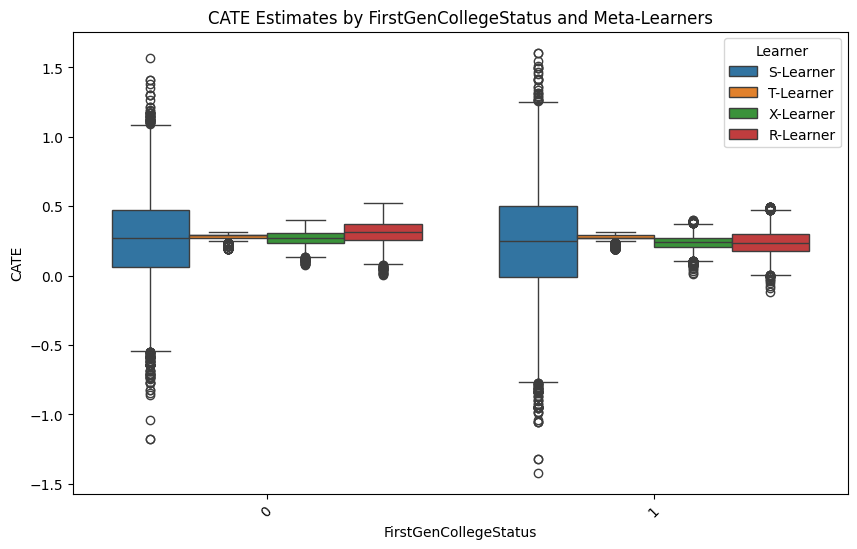

In [19]:

# Plot for First-Generation College Status
plot_cate_by_demographic('FirstGenCollegeStatus')

3. CATE Estimates by First-Generation College Status

This boxplot shows the distribution of CATE estimates for students who are or are not first-generation college students (FirstGenCollegeStatus).
* Key Observations:

    * First-Generation Students (1):
    The R-Learner again estimates a higher treatment effect (~0.4), indicating that the intervention may have a stronger impact on first-generation students.
    The S-Learner, T-Learner, and X-Learner predict lower treatment effects, with the median CATE around 0.2-0.3.
    * Non-First-Generation Students (0):
    The R-Learner estimates a more concentrated distribution of CATE (median ~0.3), suggesting that it predicts consistent effects for non-first-generation students.
    The other learners show narrower ranges and slightly lower medians, suggesting that they predict more modest treatment effects for this group.
* Interpretation:

    * First-generation students might benefit more from the growth mindset intervention, as indicated by the R-Learner's higher estimates.
    * The intervention appears to have a more variable effect on non-first-generation students, but less pronounced compared to first-generation students.

# General Conclusions:
## R-Learner vs. Other Meta-Learners:

Across all demographic subgroups, the R-Learner consistently predicts higher treatment effects than the other learners. This suggests that the R-Learner is more sensitive to feature-level variation in estimating CATE. This could indicate that it is better at capturing heterogeneity in treatment effects based on demographic and contextual variables.
In contrast, S-Learner, T-Learner, and X-Learner tend to provide more conservative estimates with narrower spreads across different subgroups.

* Demographic Sensitivity:

    * Gender: Females might benefit more from the intervention than males, as suggested by higher CATE estimates for females.
    * Race/Ethnicity: There is a significant amount of heterogeneity in treatment effects across racial groups, indicating that certain racial/ethnic groups might respond more strongly to the intervention.
    * First-Generation College Status: First-generation students show higher treatment effects, which might suggest that these students, who often face more educational challenges, benefit more from the growth mindset intervention.

* Meta-Learner Performance:

    * The R-Learner shows a broader range and higher CATE estimates, potentially capturing more variation in the treatment effect. This suggests that it might be a better choice for datasets where interaction effects and heterogeneous treatment effects are more pronounced.
    * S-Learner, T-Learner, and X-Learner might be underestimating treatment effects, especially for certain subgroups, suggesting they are less flexible in capturing this heterogeneity.

2. Propensity Score Balance
To check whether the treated and control groups are balanced across the demographic subgroups, you can calculate and visualize the distribution of propensity scores for each subgroup. This step ensures that the estimated treatment effects are not biased by imbalanced covariates.

In [20]:
from sklearn.linear_model import LogisticRegression

# Function to calculate propensity scores
def calculate_propensity_scores(data, covariates, treatment_col):
    model = LogisticRegression()
    model.fit(data[covariates], data[treatment_col])
    data['propensity_score'] = model.predict_proba(data[covariates])[:, 1]  # Probability of treatment
    return data

# Calculate propensity scores
covariates = ['FutureSuccessExpectations', 'StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 
              'SchoolUrbanicity', 'PreInterventionFixedMindset', 'SchoolAchievementLevel', 
              'SchoolMinorityComposition', 'PovertyConcentration', 'TotalStudentPopulation']
processed_data = calculate_propensity_scores(processed_data, covariates, 'GrowthMindsetIntervention')


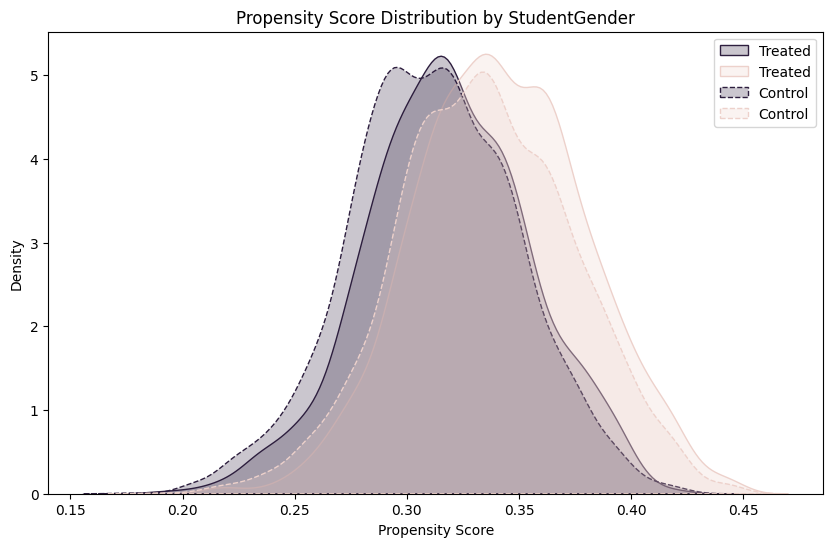

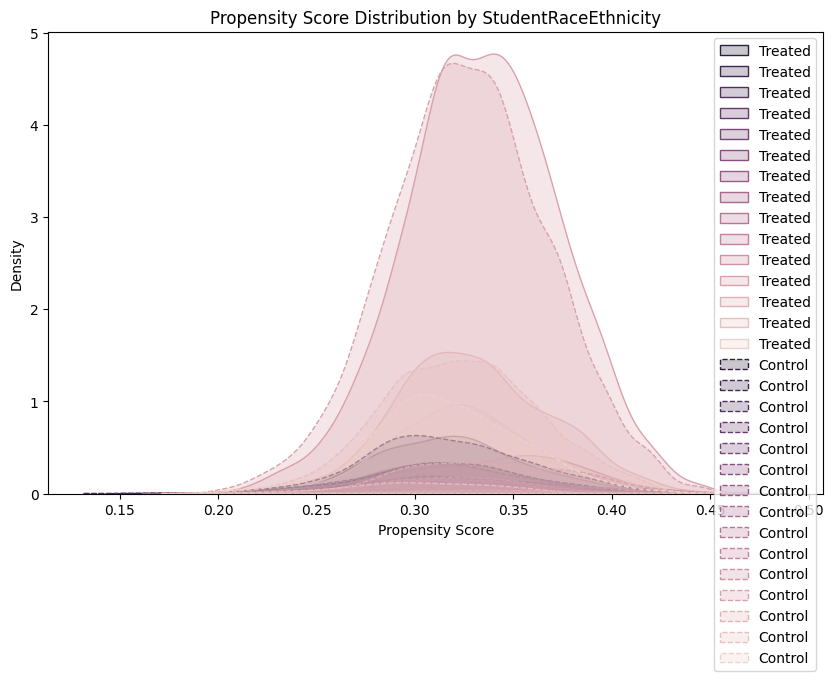

In [21]:
def plot_propensity_score_distribution(subgroup_feature):
    plt.figure(figsize=(10, 6))
    
    # Plot the density of propensity scores for treated and control groups
    sns.kdeplot(data=processed_data[processed_data['GrowthMindsetIntervention'] == 1], 
                x='propensity_score', hue=subgroup_feature, fill=True, label='Treated')
    sns.kdeplot(data=processed_data[processed_data['GrowthMindsetIntervention'] == 0], 
                x='propensity_score', hue=subgroup_feature, fill=True, linestyle='--', label='Control')
    
    plt.title(f'Propensity Score Distribution by {subgroup_feature}')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.legend(loc='best')
    plt.show()

# Example for Gender
plot_propensity_score_distribution('StudentGender')

# Example for Race/Ethnicity
plot_propensity_score_distribution('StudentRaceEthnicity')


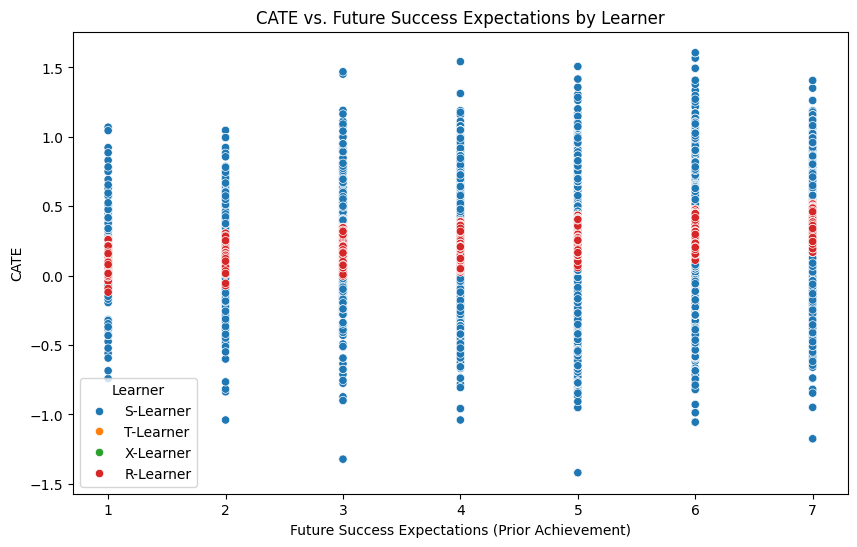

In [22]:
def plot_cate_vs_prior_achievement():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='FutureSuccessExpectations', y='CATE', hue='Learner', data=combined_data)
    plt.title('CATE vs. Future Success Expectations by Learner')
    plt.xlabel('Future Success Expectations (Prior Achievement)')
    plt.ylabel('CATE')
    plt.show()

# Plot CATE against prior achievement expectations
plot_cate_vs_prior_achievement()


Cluster-Based Heatmaps:

Instead of plotting every unique value of PovertyConcentration and SchoolAchievementLevel, you could cluster these variables into low, medium, and high categories. This would make the heatmap easier to interpret without overwhelming the viewer with granular levels.

Example Code for Binning

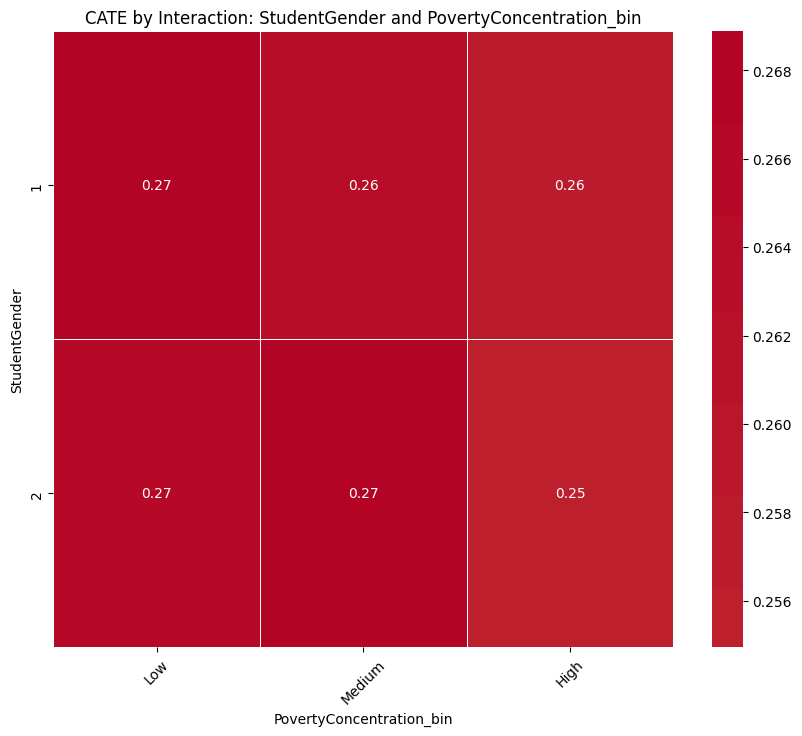

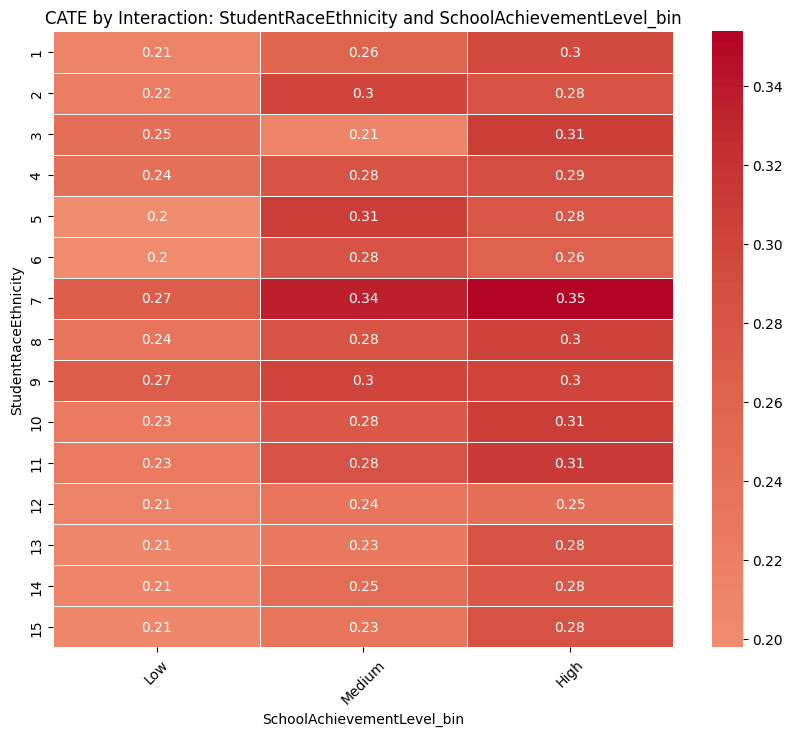

In [23]:
# Example of binning the poverty concentration into 3 categories
combined_data['PovertyConcentration_bin'] = pd.qcut(combined_data['PovertyConcentration'], 3, labels=['Low', 'Medium', 'High'])

# Binning school achievement levels
combined_data['SchoolAchievementLevel_bin'] = pd.qcut(combined_data['SchoolAchievementLevel'], 3, labels=['Low', 'Medium', 'High'])

def plot_cate_by_interaction(student_feature, school_feature):
    # Group by the combination of student-level and school-level feature and calculate mean CATE
    interaction_data = combined_data.groupby([student_feature, school_feature]).agg({'CATE': 'mean'}).reset_index()
    
    # Pivot the data to visualize with a heatmap
    interaction_pivot = interaction_data.pivot(index=student_feature, columns=school_feature, values='CATE')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(interaction_pivot, annot=True, cmap="coolwarm", center=0, linewidths=.5)
    plt.title(f'CATE by Interaction: {student_feature} and {school_feature}')
    plt.xlabel(school_feature)
    plt.ylabel(student_feature)
    plt.xticks(rotation=45)
    plt.show()


# Now re-plot with the binned categories
plot_cate_by_interaction('StudentGender', 'PovertyConcentration_bin')
plot_cate_by_interaction('StudentRaceEthnicity', 'SchoolAchievementLevel_bin')


Interaction Plots:

Use interaction plots to explore the relationship between two factors (e.g., gender and poverty concentration) and CATE estimates. Interaction plots can show how the change in one variable (e.g., poverty) affects the treatment effect differently for males and females

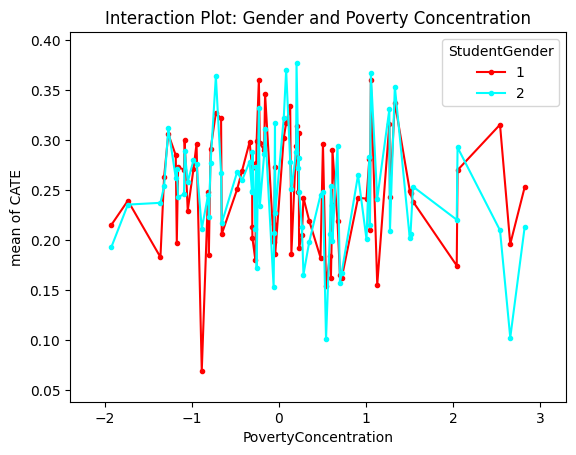

In [24]:
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot

# Example for Gender and PovertyConcentration
interaction_plot(combined_data['PovertyConcentration'], combined_data['StudentGender'], combined_data['CATE'])
plt.title("Interaction Plot: Gender and Poverty Concentration")
plt.show()
